In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from torch import nn
import lightning as L
import matplotlib.pyplot as plt
from transphorm.model_components.data_objects import SyntheticFPDataModule
from transphorm.model_components.model_modules import AutoEncoder, DilatedCNNDecoder, DilatedCNNEncoder
from pathlib import Path
import seaborn as sns
import os
import numpy as np
from dotenv import load_dotenv

load_dotenv()

True

In [13]:

model_path = "/Users/mds8301/Development/transphorm/autoencoders/a7a31bb0c5ad400697f131fb72a4fe6f/checkpoints/epoch=999-step=22000.ckpt"
data_path = os.getenv("DATA_PATH")

data_mod = SyntheticFPDataModule(data_path)
data_mod.prepare_data()
data_mod.setup("test")

model = AutoEncoder.load_from_checkpoint(model_path, encoder = DilatedCNNEncoder, decoder = DilatedCNNDecoder)

In [14]:
model.eval()
model.to('cpu')

AutoEncoder(
  (encoder): DilatedCNNEncoder(
    (cnn_layers): Sequential(
      (0): Conv1d(3, 8, kernel_size=(10,), stride=(10,), padding=(15,))
      (1): ReLU()
      (2): Conv1d(8, 16, kernel_size=(4,), stride=(5,), dilation=(2,))
      (3): ReLU()
      (4): Conv1d(16, 32, kernel_size=(1,), stride=(1,), dilation=(4,))
      (5): ReLU()
      (6): Flatten(start_dim=-2, end_dim=-1)
    )
    (linear_layers): Sequential(
      (0): Linear(in_features=640, out_features=512, bias=True)
      (1): ReLU()
      (2): Linear(in_features=512, out_features=256, bias=True)
      (3): ReLU()
      (4): Linear(in_features=256, out_features=128, bias=True)
    )
  )
  (decoder): DilatedCNNDecoder(
    (linear_decoder): Sequential(
      (0): Linear(in_features=128, out_features=256, bias=True)
      (1): ReLU()
      (2): ReLU()
      (3): Linear(in_features=256, out_features=512, bias=True)
      (4): ReLU()
      (5): Linear(in_features=512, out_features=640, bias=True)
      (6): ReLU()
    

In [17]:
data_mod.test

In [20]:


def detach_to_np(tensor):
    tensor.to('cpu')
    return tensor.detach().numpy()

def get_random_data(subset: torch.utils.data.dataset.Subset):
    rand_idx = np.random.randint(0, 100)
    x = subset[rand_idx][0]
    return x

def plot_data(x, x_hat):
    fig, ax = plt.subplot_mosaic(mosaic='ABC', **{'figsize': (18,6)})
    ax['A'].plot(x[0], color = 'k')
    ax['A'].plot(x_hat[0], color = 'r')
    ax['B'].plot(x[1], color = 'k')
    ax['B'].plot(x_hat[1], color = 'r')
    ax['C'].plot(x[2], color = 'k')
    ax['C'].plot(x_hat[2], color = 'r')
    ax['A'].title.set_text('Signal')
    ax['B'].title.set_text('Timestamps vector 1')
    ax['C'].title.set_text('Timestamps vector 2')

# Dialted CNN does not preserve any orientation of timestamps on new data
---


## Test Data

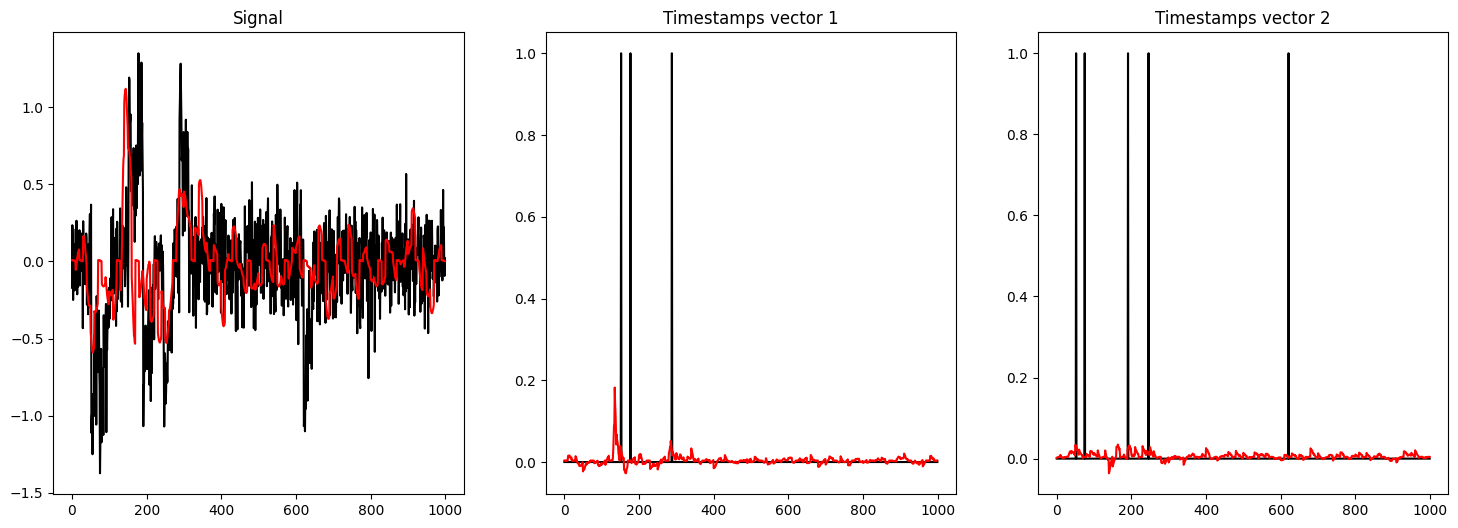

In [24]:
def inference(model, subset):
    x = get_random_data(subset)
    x_hat = model(x)
    return detach_to_np(x), detach_to_np(x_hat)

x_test, x_hat_test = inference(model, data_mod.test)

plot_data(x_test, x_hat_test)


## Lack of timestamp encoding asscoiated with overfitting

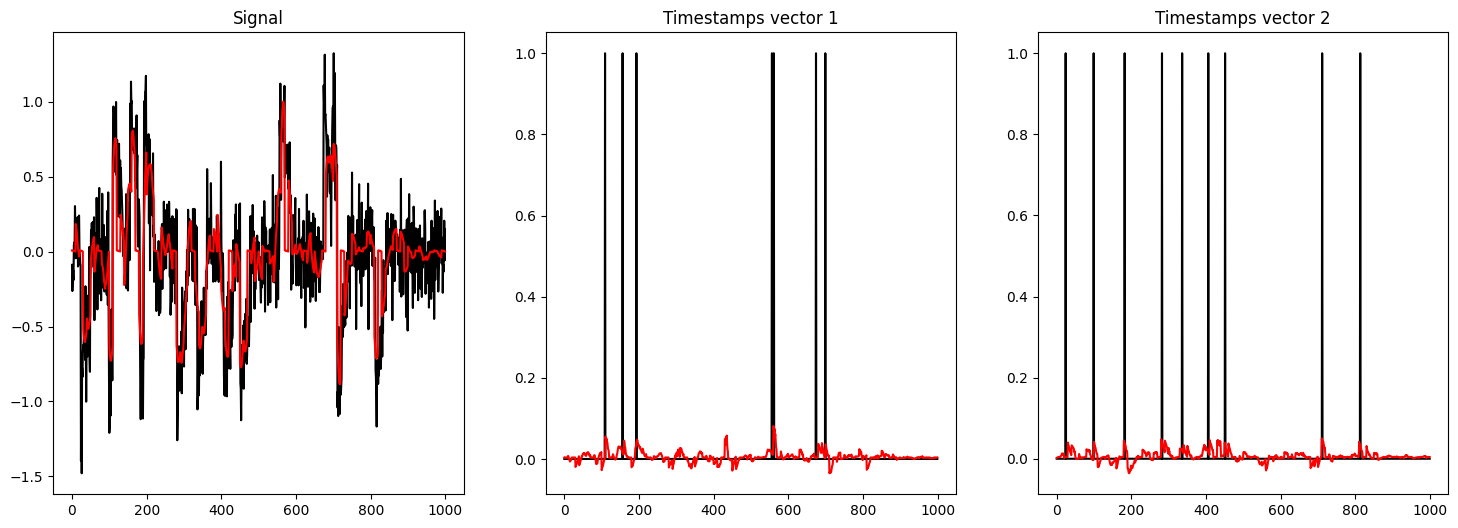

In [26]:
x_train, x_hat_train = inference(model, data_mod.train)
plot_data(x_train, x_hat_train)